In [1]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Load the dataset
data = pd.read_csv('understat_per_game.csv')

In [3]:
# Step 2: Handle outliers in the target variable ('scored') using the IQR method
Q1 = data['scored'].quantile(0.25)
Q3 = data['scored'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data = data[(data['scored'] >= lower_bound) & (data['scored'] <= upper_bound)]
print(f"Dataset shape after removing outliers: {data.shape}")

Dataset shape after removing outliers: (24420, 29)


In [4]:
# Step 3: Create target classes for binary classification (under 2.5 goals = 0, over 2.5 goals = 1)
def classify_binary_goals(goals):
    return 1 if goals > 2.5 else 0

data['scored_binary'] = data['scored'].apply(classify_binary_goals)

In [5]:
# Step 4: Drop high-correlation features and non-useful columns
high_corr_features = ['pts', 'npxG', 'npxGD', 'xG', 'xG_diff', 'wins', 'npxG', 
                      'xpts', 'xGA_diff', 'xGA', 'npxGA', 'xpts_diff', 'loses', 'draws']
data = data.drop(columns=high_corr_features + ['result', 'date', 'team', 'scored'])

In [6]:
# Apply one-hot encoding to categorical columns ('h_a', 'league')
data = pd.get_dummies(data, columns=['h_a', 'league'], drop_first=True)

In [7]:
# Step 6: Define target and features for binary classification
X = data.drop(columns=['scored_binary'])  # Features
y = data['scored_binary']  # Target variable (binary classes)

In [8]:
# Step 7: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 8: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Accuracy: 0.6744

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      4113
           1       0.26      0.57      0.36       771

    accuracy                           0.67      4884
   macro avg       0.58      0.63      0.57      4884
weighted avg       0.80      0.67      0.71      4884



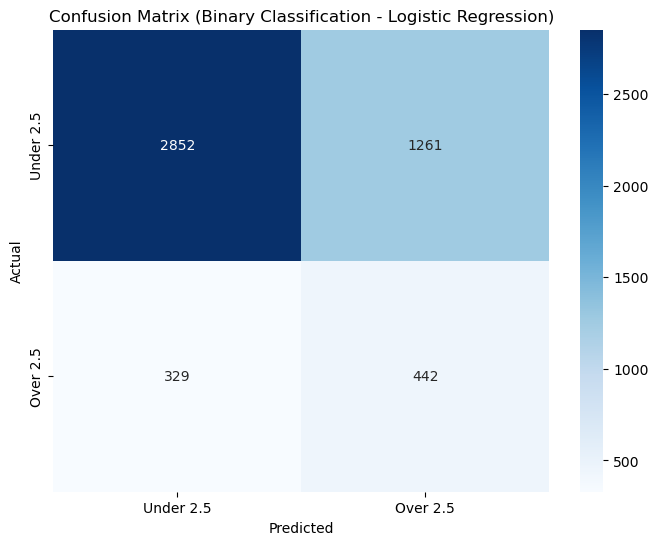


Cross-Validation Accuracy:
Mean: 0.6732, Std: 0.0083
Scores: [0.6678608  0.66803174 0.68927566 0.66777579 0.67315076]


In [9]:
# Step 9: Initialize Logistic Regression Model
logistic_model = LogisticRegression(
    max_iter=2000, 
    random_state=42, 
    solver='lbfgs', 
    class_weight='balanced'
)

# Step 10: Train the model
logistic_model.fit(X_train, y_train)

# Step 11: Make predictions
y_pred = logistic_model.predict(X_test)

# Step 12: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Under 2.5', 'Over 2.5'], yticklabels=['Under 2.5', 'Over 2.5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Binary Classification - Logistic Regression)')
plt.show()

# Step 13: Cross-Validation Accuracy
cv_scores = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy:")
print(f"Mean: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")
print(f"Scores: {cv_scores}")


Importance based on Logistic Regression:
           Feature  Importance
1             deep    0.540461
5         ppda_att    0.236546
8        oppda_att    0.216134
14     league_RFPL    0.192951
3           missed    0.159281
10           h_a_h    0.150179
6         ppda_def    0.133694
4        ppda_coef    0.118627
12  league_La_liga    0.104464
11      league_EPL    0.102466
13  league_Ligue_1    0.101281
15  league_Serie_A    0.092609
2     deep_allowed    0.089767
0             year    0.042750
7       oppda_coef    0.028229
9        oppda_def    0.002464


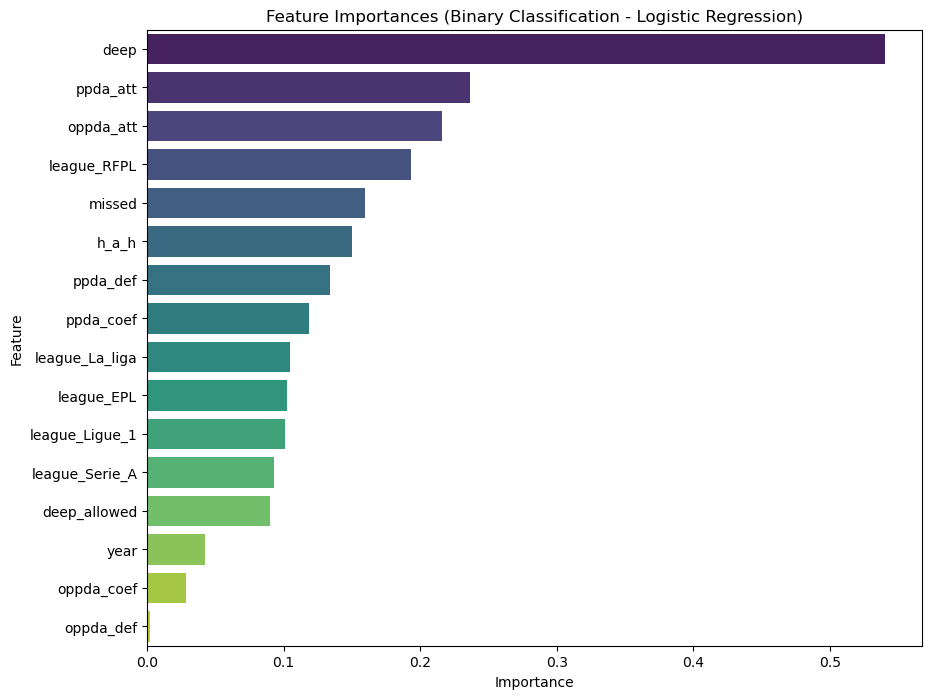

In [13]:
# Step 14: Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(logistic_model.coef_).flatten()  # Importance is the absolute value of coefficients
}).sort_values(by='Importance', ascending=False)

print("\nImportance based on Logistic Regression:")
print(feature_importance.head(20))

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances (Binary Classification - Logistic Regression)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()